In [8]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/Users/ohheungchan/workspace/AI_Study/Paperwork/human+activity+recognition+using+smartphones/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot


In [12]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [14]:

print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [15]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [16]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [17]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [18]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [19]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)
     

In [20]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]


In [31]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 flatten_2 (Flatten)         (None, 8064)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1032320   
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,034,886
Trainable params: 1,034,886
Non-trainable params: 0
_________________________________________________________________


In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
 1/58 [..............................] - ETA: 17s - loss: 1.7781 - accuracy: 0.1953

2024-03-07 17:14:35.771063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8002

2024-03-07 17:14:36.760591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 1s 19ms/step - loss: 0.4980 - accuracy: 0.8002 - val_loss: 0.2877 - val_accuracy: 0.9003
Epoch 2/10
58/58 [==============================] - 1s 15ms/step - loss: 0.1929 - accuracy: 0.9323 - val_loss: 0.1431 - val_accuracy: 0.9515
Epoch 3/10
58/58 [==============================] - 1s 16ms/step - loss: 0.1314 - accuracy: 0.9495 - val_loss: 0.1403 - val_accuracy: 0.9406
Epoch 4/10
58/58 [==============================] - 1s 15ms/step - loss: 0.1183 - accuracy: 0.9512 - val_loss: 0.1066 - val_accuracy: 0.9565
Epoch 5/10
58/58 [==============================] - 1s 15ms/step - loss: 0.1065 - accuracy: 0.9563 - val_loss: 0.1003 - val_accuracy: 0.9597
Epoch 6/10
58/58 [==============================] - 1s 15ms/step - loss: 0.1052 - accuracy: 0.9546 - val_loss: 0.1022 - val_accuracy: 0.9578
Epoch 7/10
58/58 [==============================] - 1s 15ms/step - loss: 0.0963 - accuracy: 0.9574 - val_loss: 0.1007 - val_accuracy: 0.9592
Epoch 8/10
58/58 [======

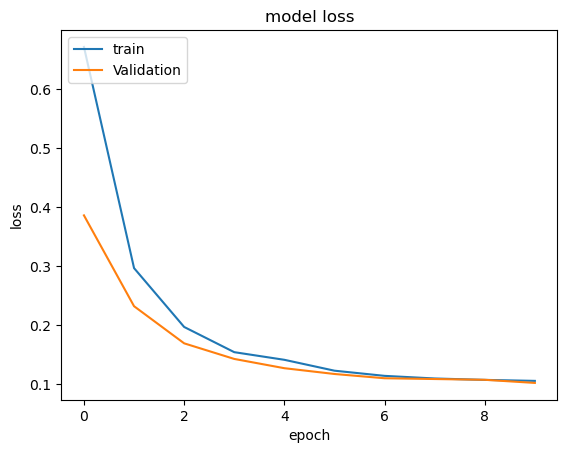

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

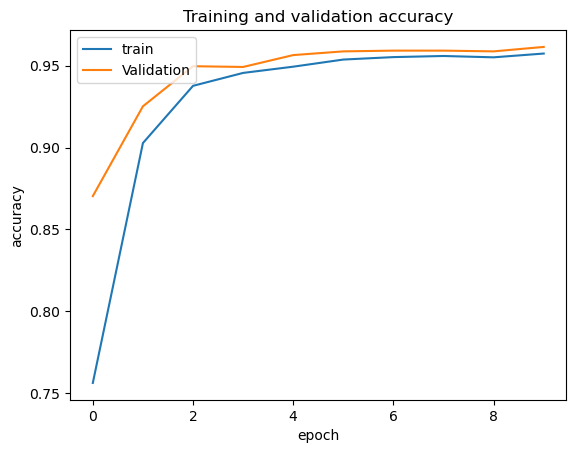

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

82/93 [=========================>....] - ETA: 0s

2024-03-07 16:59:35.967567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 0s 2ms/step
[[460   1  35   0   0   0]
 [ 16 427  28   0   0   0]
 [  4   2 413   1   0   0]
 [  0  25   0 406  60   0]
 [  0  12   0  86 434   0]
 [  0  10   0   0   0 527]]
0.9049881235154394
0.9047261046154824
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       496
           1       0.90      0.91      0.90       471
           2       0.87      0.98      0.92       420
           3       0.82      0.83      0.83       491
           4       0.88      0.82      0.85       532
           5       1.00      0.98      0.99       537

    accuracy                           0.90      2947
   macro avg       0.90      0.91      0.90      2947
weighted avg       0.91      0.90      0.90      2947



<Axes: >

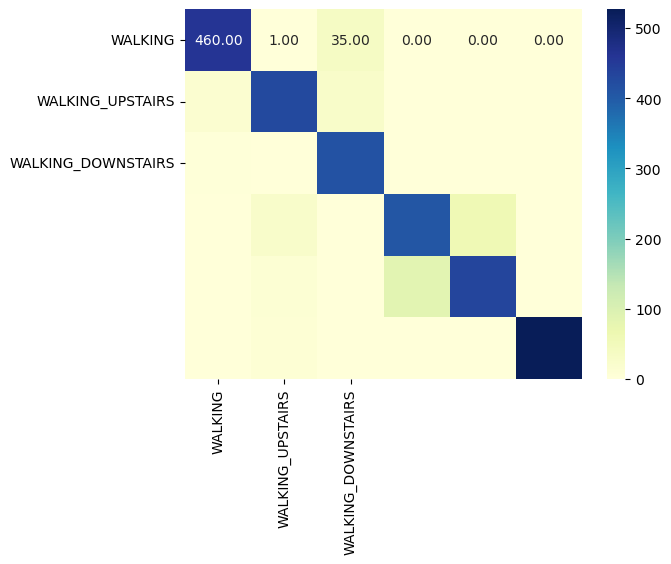

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [33]:
# Model 2
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_4 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 flatten_3 (Flatten)         (None, 7936)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1015936   
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1,030,854
Trainable params: 1,030,854
Non-trainable params: 0
_________________________________________________________________


In [34]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-08 02:00:51.423265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.8006

2024-03-08 02:00:52.629523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 2s 23ms/step - loss: 0.5030 - accuracy: 0.8006 - val_loss: 0.2163 - val_accuracy: 0.9365
Epoch 2/10
58/58 [==============================] - 1s 17ms/step - loss: 0.1636 - accuracy: 0.9358 - val_loss: 0.1240 - val_accuracy: 0.9519
Epoch 3/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1259 - accuracy: 0.9499 - val_loss: 0.1167 - val_accuracy: 0.9556
Epoch 4/10
58/58 [==============================] - 1s 17ms/step - loss: 0.1183 - accuracy: 0.9527 - val_loss: 0.1055 - val_accuracy: 0.9592
Epoch 5/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1071 - accuracy: 0.9555 - val_loss: 0.1113 - val_accuracy: 0.9483
Epoch 6/10
58/58 [==============================] - 1s 17ms/step - loss: 0.0998 - accuracy: 0.9569 - val_loss: 0.1033 - val_accuracy: 0.9583
Epoch 7/10
58/58 [==============================] - 1s 17ms/step - loss: 0.1013 - accuracy: 0.9563 - val_loss: 0.0929 - val_accuracy: 0.9619
Epoch 8/10
58/58 [======

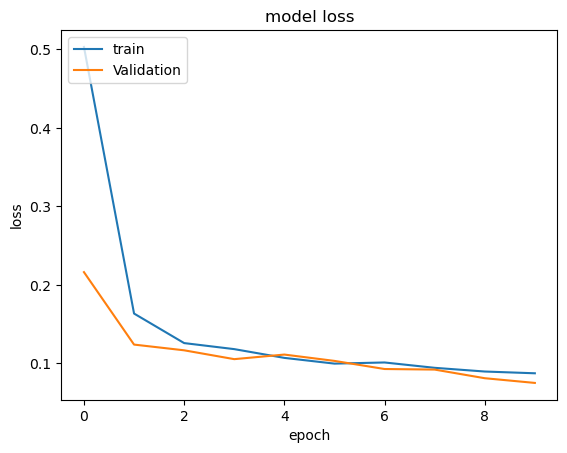

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

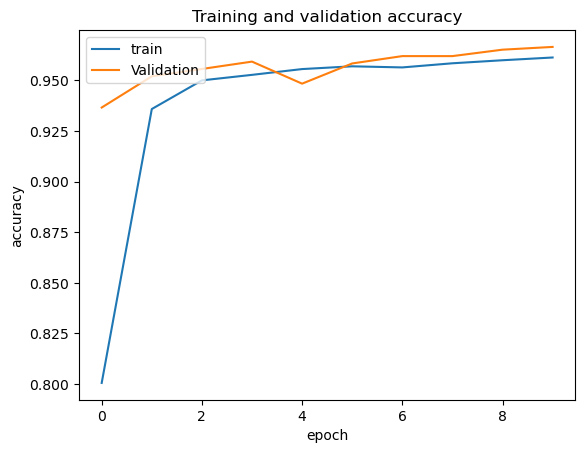

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

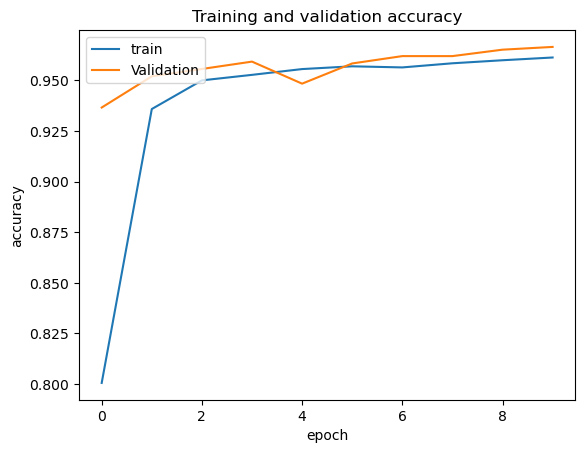

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/93 [====================>.........] - ETA: 0s

2024-03-08 02:01:41.362742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 0s 3ms/step
[[474   4  18   0   0   0]
 [  8 437  26   0   0   0]
 [  7   1 412   0   0   0]
 [  0  25   0 410  56   0]
 [  0   4   0  89 439   0]
 [  0  27   0   0   0 510]]
0.9100780454699695
0.9100492875716216
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       496
           1       0.88      0.93      0.90       471
           2       0.90      0.98      0.94       420
           3       0.82      0.84      0.83       491
           4       0.89      0.83      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

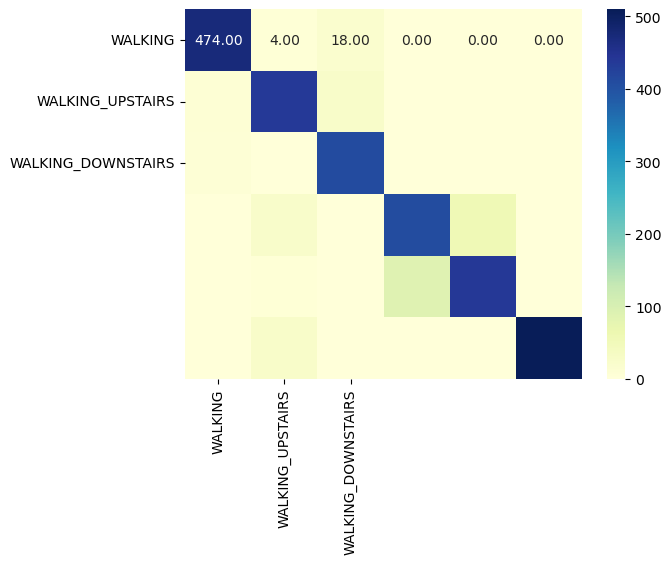

In [38]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [39]:
# Model 3
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_6 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_7 (Conv1D)           (None, 122, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 61, 64)           0         
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 3904)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               499840    
                                                      

In [40]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-08 02:02:04.049051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7733

2024-03-08 02:02:05.524824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 2s 28ms/step - loss: 0.5665 - accuracy: 0.7733 - val_loss: 0.2802 - val_accuracy: 0.9053
Epoch 2/10
58/58 [==============================] - 1s 19ms/step - loss: 0.2057 - accuracy: 0.9172 - val_loss: 0.1525 - val_accuracy: 0.9379
Epoch 3/10
58/58 [==============================] - 1s 19ms/step - loss: 0.1270 - accuracy: 0.9493 - val_loss: 0.1146 - val_accuracy: 0.9533
Epoch 4/10
58/58 [==============================] - 1s 19ms/step - loss: 0.1221 - accuracy: 0.9484 - val_loss: 0.1357 - val_accuracy: 0.9383
Epoch 5/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1259 - accuracy: 0.9468 - val_loss: 0.1084 - val_accuracy: 0.9506
Epoch 6/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1029 - accuracy: 0.9566 - val_loss: 0.1070 - val_accuracy: 0.9524
Epoch 7/10
58/58 [==============================] - 1s 18ms/step - loss: 0.0995 - accuracy: 0.9578 - val_loss: 0.0960 - val_accuracy: 0.9592
Epoch 8/10
58/58 [======

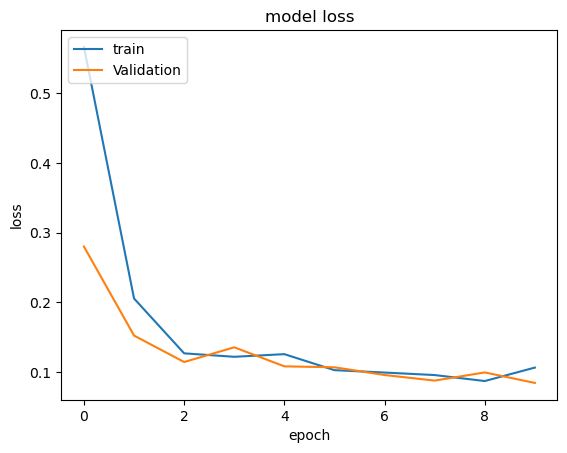

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

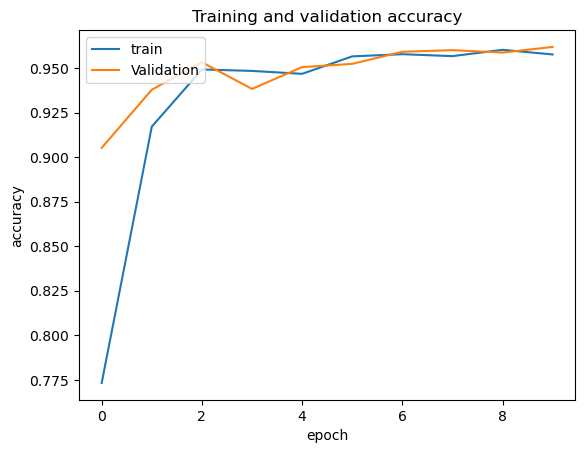

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

37/93 [==========>...................] - ETA: 0s

2024-03-08 02:02:32.573314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 0s 3ms/step
[[487   0   9   0   0   0]
 [  9 436  26   0   0   0]
 [  3   0 417   0   0   0]
 [  1  23   0 425  39   3]
 [  2   4   0 105 421   0]
 [  0   0   0   0   0 537]]
0.9239904988123515
0.9234239609855681
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       496
           1       0.94      0.93      0.93       471
           2       0.92      0.99      0.96       420
           3       0.80      0.87      0.83       491
           4       0.92      0.79      0.85       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.93      0.92      2947
weighted avg       0.93      0.92      0.92      2947



<Axes: >

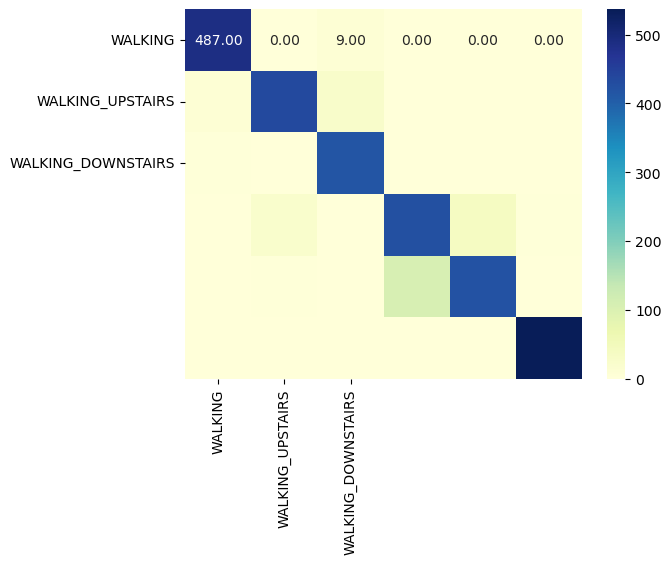

In [43]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [44]:
# Model 4
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_9 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_10 (Conv1D)          (None, 122, 64)           12352     
                                                                 
 conv1d_11 (Conv1D)          (None, 120, 64)           12352     
                                                                 
 flatten_5 (Flatten)         (None, 7680)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               983168    
                                                                 
 dense_11 (Dense)            (None, 6)                

In [45]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-08 02:02:54.198063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.5818 - accuracy: 0.7594

2024-03-08 02:02:55.726740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 2s 28ms/step - loss: 0.5818 - accuracy: 0.7594 - val_loss: 0.2423 - val_accuracy: 0.9180
Epoch 2/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1618 - accuracy: 0.9388 - val_loss: 0.1367 - val_accuracy: 0.9361
Epoch 3/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1172 - accuracy: 0.9512 - val_loss: 0.1070 - val_accuracy: 0.9583
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 0.1142 - accuracy: 0.9521 - val_loss: 0.1102 - val_accuracy: 0.9565
Epoch 5/10
58/58 [==============================] - 1s 20ms/step - loss: 0.1042 - accuracy: 0.9544 - val_loss: 0.0987 - val_accuracy: 0.9578
Epoch 6/10
58/58 [==============================] - 1s 20ms/step - loss: 0.0997 - accuracy: 0.9547 - val_loss: 0.0993 - val_accuracy: 0.9515
Epoch 7/10
58/58 [==============================] - 1s 20ms/step - loss: 0.0978 - accuracy: 0.9562 - val_loss: 0.0948 - val_accuracy: 0.9624
Epoch 8/10
58/58 [======

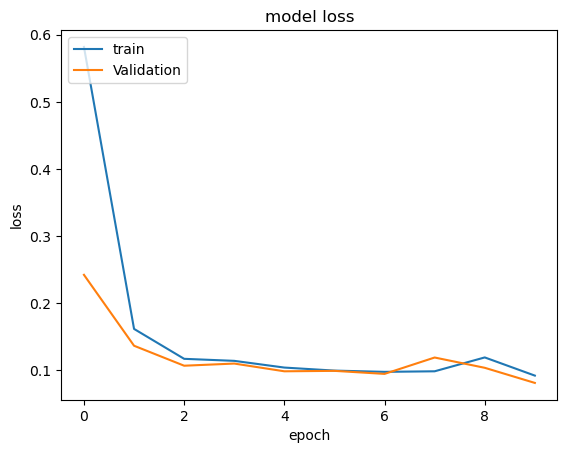

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

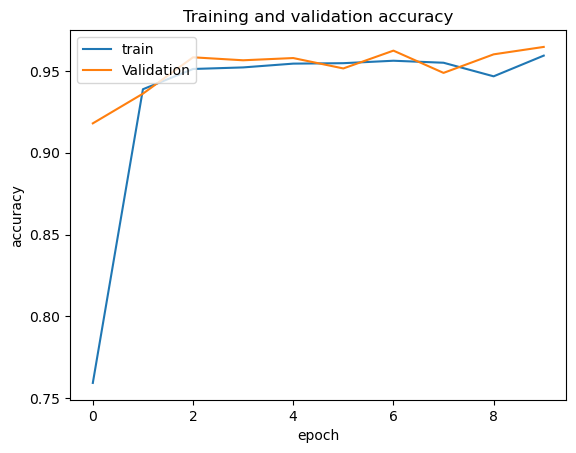

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

38/93 [===========>..................] - ETA: 0s

2024-03-08 02:03:20.667747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 0s 3ms/step
[[492   3   1   0   0   0]
 [  3 451  17   0   0   0]
 [ 13   1 406   0   0   0]
 [  1  25   0 413  52   0]
 [  0   3   0  76 453   0]
 [  0  27   0   0   0 510]]
0.9246691550729556
0.9245236871683145
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       496
           1       0.88      0.96      0.92       471
           2       0.96      0.97      0.96       420
           3       0.84      0.84      0.84       491
           4       0.90      0.85      0.87       532
           5       1.00      0.95      0.97       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.92      0.92      2947



<Axes: >

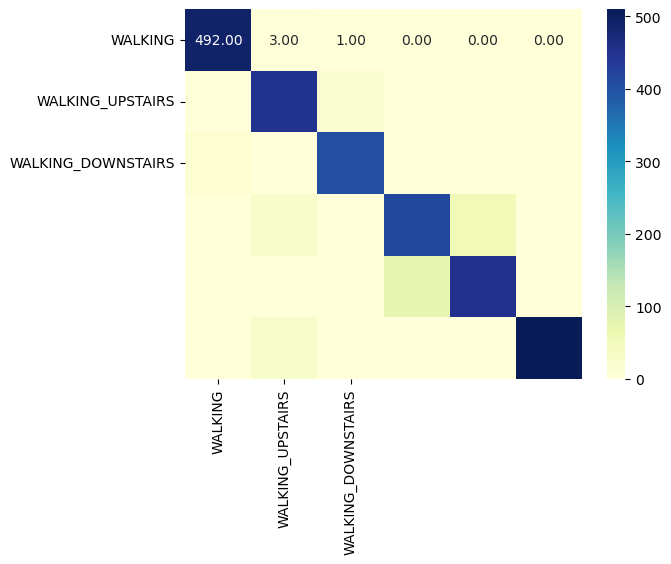

In [48]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [50]:
# Model 5
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 conv1d_18 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 conv1d_19 (Conv1D)          (None, 122, 64)           12352     
                                                                 
 conv1d_20 (Conv1D)          (None, 120, 64)           12352     
                                                                 
 conv1d_21 (Conv1D)          (None, 118, 64)           12352     
                                                                 
 flatten_7 (Flatten)         (None, 7552)              0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [51]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)
     

Epoch 1/10


2024-03-08 02:03:40.761803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.7557

2024-03-08 02:03:42.528366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 3s 32ms/step - loss: 0.5996 - accuracy: 0.7557 - val_loss: 0.2581 - val_accuracy: 0.9044
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.1821 - accuracy: 0.9300 - val_loss: 0.1625 - val_accuracy: 0.9433
Epoch 3/10
58/58 [==============================] - 1s 21ms/step - loss: 0.1389 - accuracy: 0.9431 - val_loss: 0.1291 - val_accuracy: 0.9547
Epoch 4/10
58/58 [==============================] - 1s 23ms/step - loss: 0.1107 - accuracy: 0.9520 - val_loss: 0.1173 - val_accuracy: 0.9474
Epoch 5/10
58/58 [==============================] - 1s 21ms/step - loss: 0.1063 - accuracy: 0.9536 - val_loss: 0.1604 - val_accuracy: 0.9383
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.1124 - accuracy: 0.9506 - val_loss: 0.1190 - val_accuracy: 0.9538
Epoch 7/10
58/58 [==============================] - 1s 21ms/step - loss: 0.1171 - accuracy: 0.9529 - val_loss: 0.1098 - val_accuracy: 0.9529
Epoch 8/10
58/58 [======

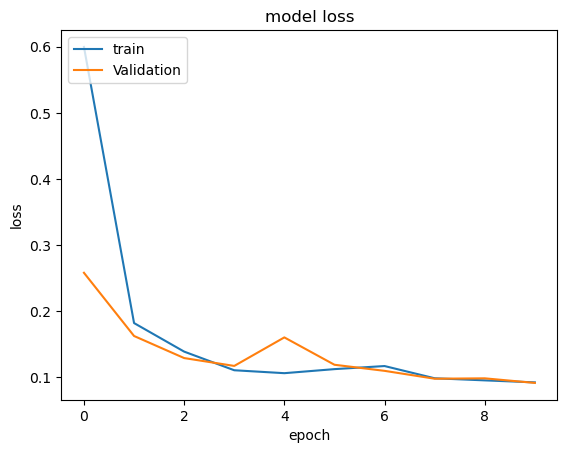

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

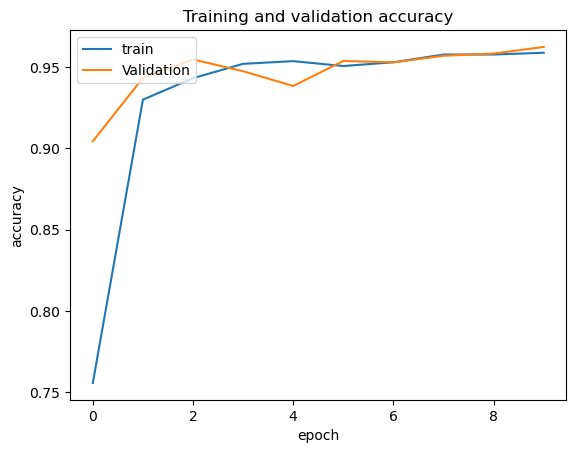

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

36/93 [==========>...................] - ETA: 0s

2024-03-08 02:04:08.966295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 0s 3ms/step
[[467   6  23   0   0   0]
 [  0 445  26   0   0   0]
 [ 17   4 399   0   0   0]
 [  0  23   0 396  70   2]
 [  2   0   0 111 419   0]
 [  0  26   0   0   0 511]]
0.8948082796063793
0.8947406930063989
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       496
           1       0.88      0.94      0.91       471
           2       0.89      0.95      0.92       420
           3       0.78      0.81      0.79       491
           4       0.86      0.79      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.90      0.90      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

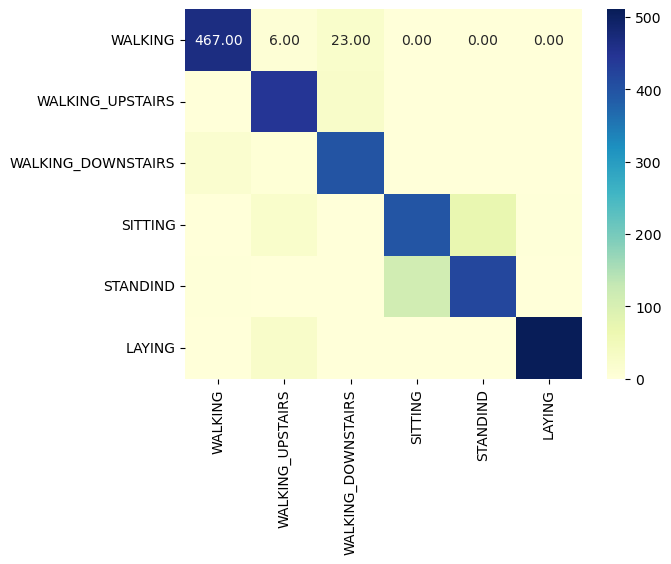

In [54]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

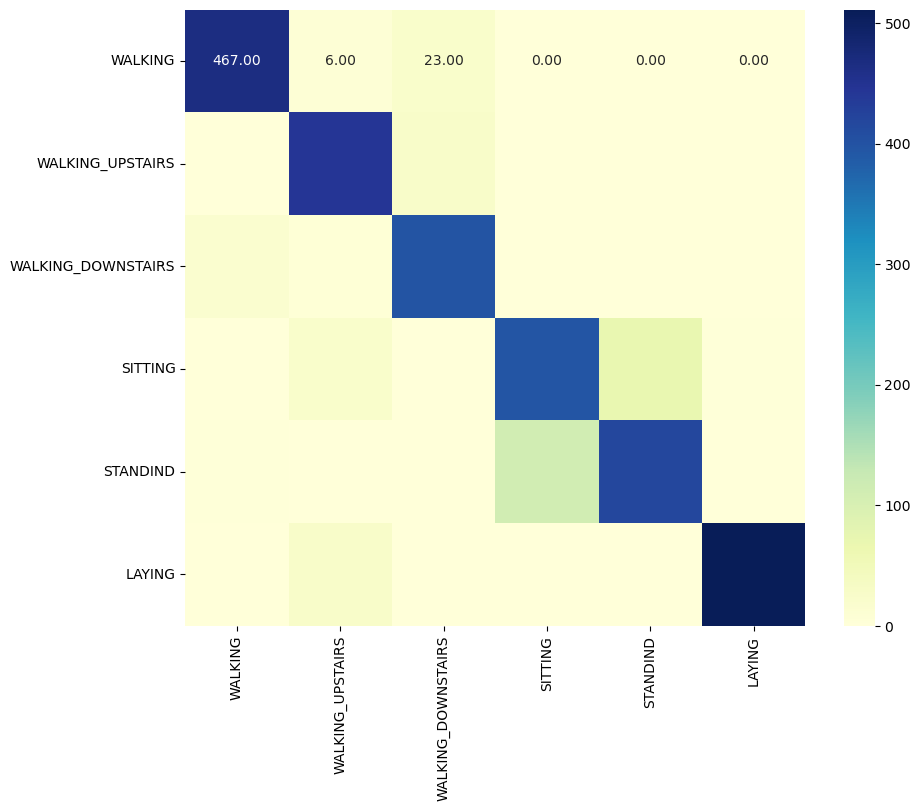

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히트맵 크기 조정을 위한 Matplotlib Figure 설정
plt.figure(figsize=(10, 8))

# 히트맵 생성
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='.2f')

# 히트맵 출력
plt.show()